## CNN | Sound Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import soundata
import os
from tqdm import tqdm
import librosa
from IPython.display import Audio
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

### Почему нельзя просто использовать "сырые" аудиосигналы?

Аудиосигналы - это непрерывные волны изменений звукового давления во времени. При оцифровке они превращаются в последовательности амплитудных значений, отсчётов, равномерно взятых во времени (например, 22 050 отсчётов в секунду). Теоретически, можно подавать исходные волны напрямую в нейронные сети, но такой подход сталкивается с рядом проблем:

1. **Высокая размерность**. 4-секундный аудиофрагмент с частотой 22 кГц содержит 88 000 отсчётов.
2. **Сложная временная структура**. Последовательная природа сигнала затрудняет одновременное захватывание локальных и глобальных паттернов.
3. **Нет явной информации о частотах**. В сыром сигнале не видно, какие частоты присутствуют.

#### Спектрограммы:

Спектрограмма - это визуальное представление частотного спектра сигнала во времени. Она преобразует 1D аудио в 2D-картинку, где:
- Ось X: время.
- Ось Y: частота.
- Интенсивность цвета: амплитуда (энергия) каждой частоты в конкретный момент времени.

Спектрограммы строятся с помощью **Кратковременного Преобразования Фурье (STFT)**, которое:
1. Делит аудио на короткие перекрывающиеся окна.
2. Применяет преобразование Фурье к каждому окну, чтобы извлечь частотную информацию.
3. Объединяет частотные срезы, показывая, как спектр меняется со временем.

### Мел-спектрограмма: Аудио через призму человеческого слуха

Обычные спектрограммы полезны, но не соответствуют тому, как человек воспринимает звук. Мел-спектрограммы устраняют это с помощью двух ключевых преобразований:

##### 1. Мел-шкала (ось частот)
Человек не воспринимает частоты линейно. Мы более чувствительны к изменениям в низких частотах, чем в высоких:
- Мы легко различаем 100 Гц и 200 Гц (разница 100 Гц).
- Но частоты 10 000 Гц и 10 100 Гц звучат почти одинаково (та же разница 100 Гц!).

**Мел-шкала** - это перцептивная шкала, соответствующая восприятию высоты тона человеком. Она приблизительно логарифмическая:

$$\text{mel}(f) = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)$$

##### Децибельная шкала (амплитуда/цвет)
Аналогично, мы воспринимаем громкость логарифмически, а не линейно. **Шкала децибел (дБ)** это отражает:

$$\text{dB} = 20 \cdot \log_{10}(\text{amplitude})$$

#### Почему мел-спектрограммы хороши для глубокого обучения?

1. Уменьшение размерности. Сжимаем с тысяч частотных бинов до ~128 мел-диапазонов
2. Психоакустическая релевантность. Оставляем только те частоты, которые важны для человека
3. Удобство для сверточных сетей. 2D-картинка идеально подходит для архитектур CNN
4. Проверена на практике. Современные результаты на задачах аудиоклассификации

![Пример мел-спектрограммы](https://manual.audacityteam.org/m/images/e/ed/mel_log_linear_spectrogram_annotated.png)

*Пример мел-спектрограммы: ось X - время, ось Y - частота по мел-шкале, цвет отражает амплитуду (от тёмных = низкая энергия до ярких = высокая энергия)*

Источники - [курс DLA](https://github.com/markovka17/dla), [audacity](https://manual.audacityteam.org/man/spectrogram_view.html)

## UrbanSound8K Dataset

Работаем с датасетом **UrbanSound8K**:
- 8732 размеченных фрагмента городских звуков (≤ 4 сек)
- 10 классов: `air_conditioner`, `car_horn`, `children_playing`, `dog_bark`, `drilling`, `engine_idling`, `gun_shot`, `jackhammer`, `siren`, `street_music`

Структура датасета:
```
UrbanSound8K/
├── audio/
│   ├── fold1/
│   ├── fold2/
│   └── ...
└── metadata/
    └── UrbanSound8K.csv
```

In [2]:
dataset = soundata.initialize('urbansound8k')

example_clip = dataset.choice_clip()
print(example_clip)

Clip(
  audio_path="/home/mpodsytnik/sound_datasets/urbansound8k/audio/fold9/188823-7-0-2.wav",
  clip_id="188823-7-0-2",
  audio: The clip's audio
    * np.ndarray - audio signal
    * float - sample rate,
  class_id: The clip's class id.
    * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
    * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
    * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
    * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
    * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: The clip's start time in Freesound.
    * floa

In [3]:
DATASET_PATH = os.path.join(dataset.data_home)

metadata_path = os.path.join(DATASET_PATH, "metadata", "UrbanSound8K.csv")
print("metadata_path:", metadata_path)

metadata = pd.read_csv(metadata_path)
print(f"Всего примеров: {len(metadata)}")
metadata.head()

metadata_path: /home/mpodsytnik/sound_datasets/urbansound8k/metadata/UrbanSound8K.csv
Всего примеров: 8732


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


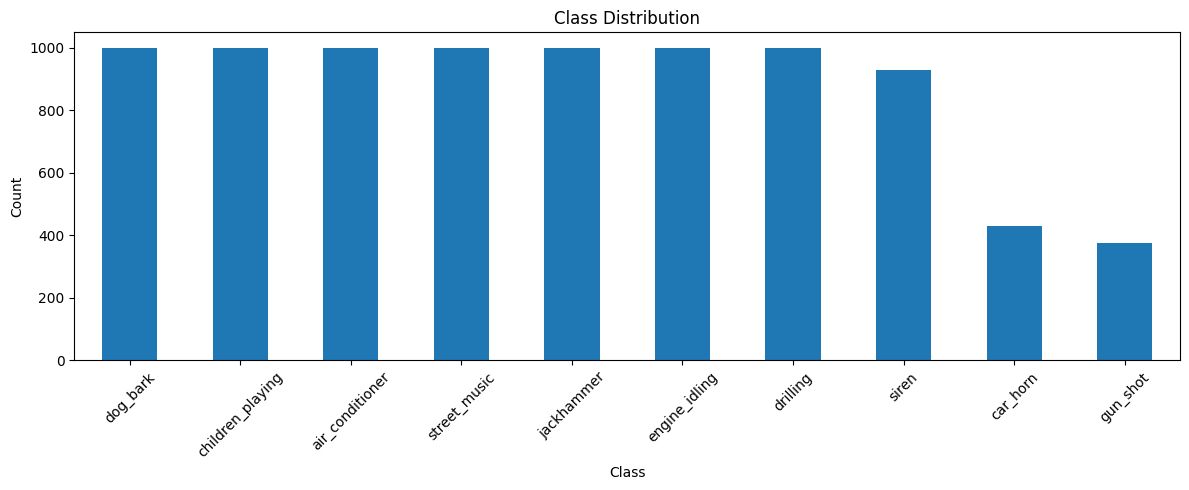

In [4]:
plt.figure(figsize=(12, 5))
metadata['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Визуализация аудио

Sample: 77233-3-0-105.wav
Class: dog_bark
Fold: 5



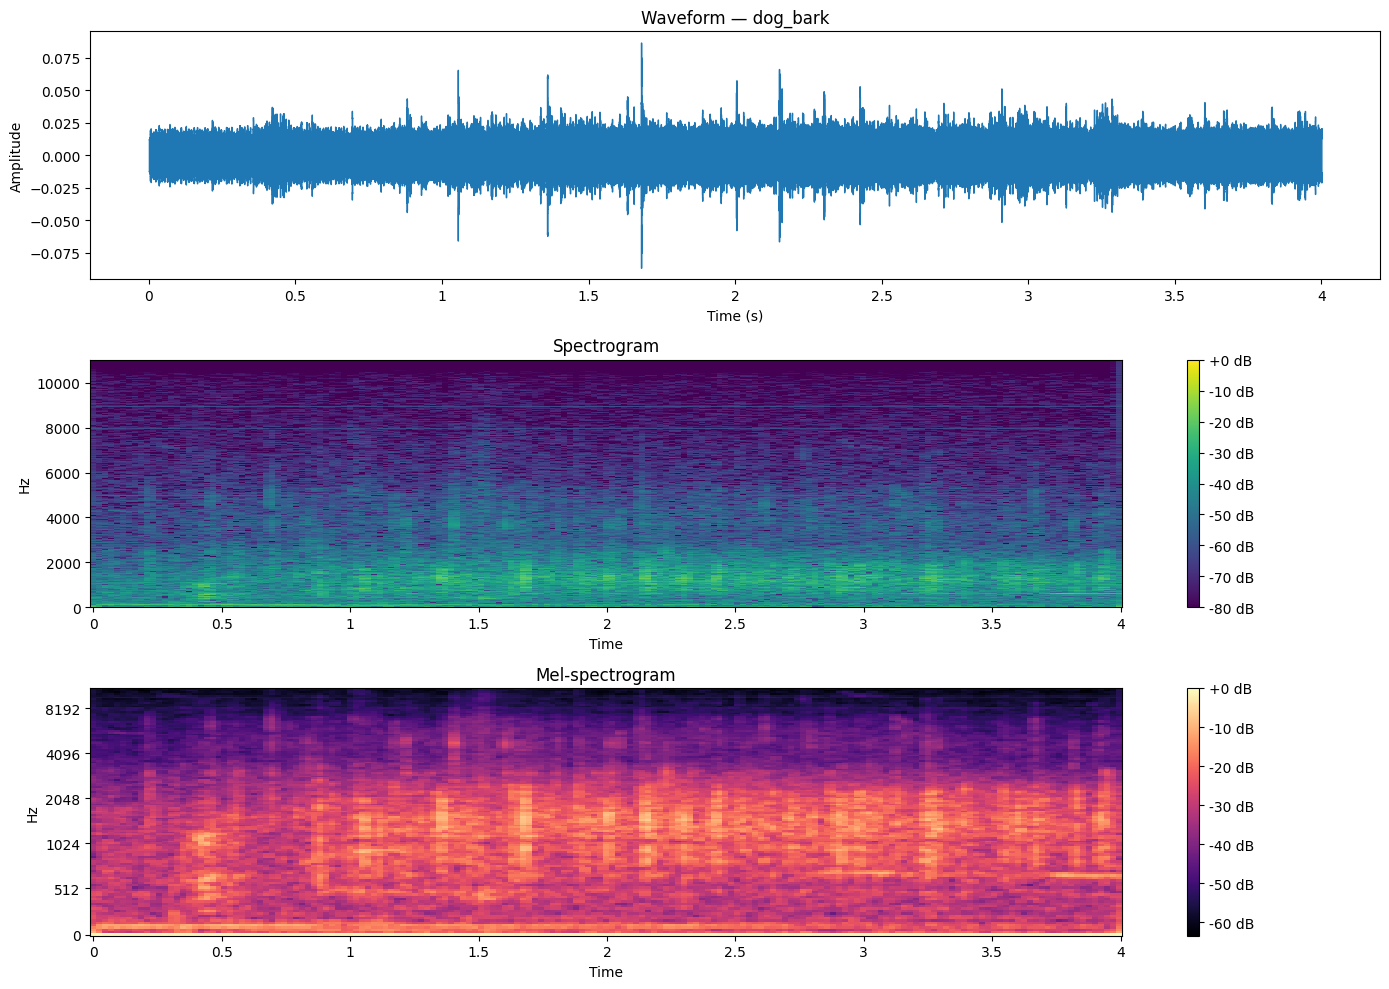

In [5]:
def plot_audio(audio_path, class_name):
    y, sr = librosa.load(audio_path, sr=22050)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    librosa.display.waveshow(y, sr=sr, ax=axes[0])
    axes[0].set_title(f'Waveform — {class_name}')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')

    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1], cmap='viridis')
    axes[1].set_title('Spectrogram')
    fig.colorbar(img1, ax=axes[1], format='%+2.0f dB')

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2], cmap='magma')
    axes[2].set_title('Mel-spectrogram')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    return y, sr

random_idx = np.random.randint(0, len(metadata))
sample = metadata.iloc[random_idx]

audio_path = os.path.join(DATASET_PATH, 'audio', f'fold{sample.fold}', sample.slice_file_name)
class_name = sample['class']

print(f"Sample: {sample.slice_file_name}")
print(f"Class: {class_name}")
print(f"Fold: {sample.fold}\n")

y, sr = plot_audio(audio_path, class_name)

Audio(y, rate=sr)


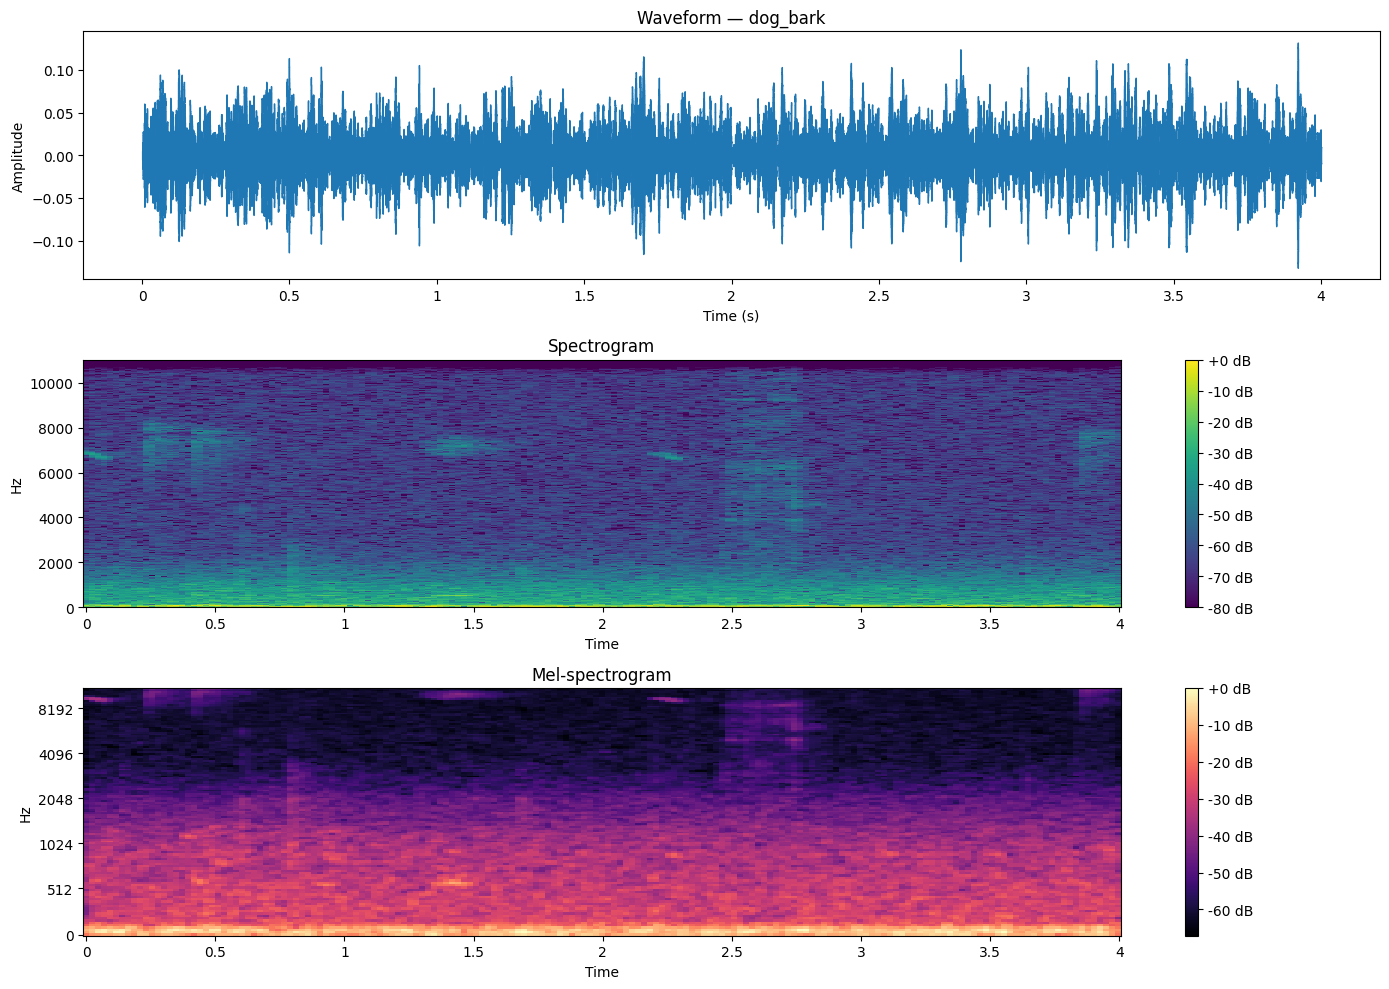

In [6]:
target_class = 'dog_bark'

class_samples = metadata[metadata['class'] == target_class]
sample = class_samples.sample(1).iloc[0]

audio_path = os.path.join(DATASET_PATH, 'audio', f'fold{sample.fold}', sample.slice_file_name)
y, sr = plot_audio(audio_path, target_class)

Audio(y, rate=sr)

## Part 3. Dataset Class

## `UrbanSoundDataset`: PyTorch Dataset для UrbanSound8K

Класс `UrbanSoundDataset` реализует загрузку аудио-клипов UrbanSound8K и преобразование их в тензоры лог-мел спектрограмм для обучения CNN. Датасет поддерживает **детерминированную предобработку** для валидации/теста и **аугментации** для обучения.

### Идея пайплайна (`__getitem__`)
Для каждого индекса:
1. **Загрузка аудио** (`load_audio`):
   - ресэмплинг до `sr`,
   - моно,
   - приведение длины к `target_length` секунд:
     - если клип короче — `zero-pad`,
     - если длиннее — **crop**:
       - `augment=True` → *random crop* (регуляризация),
       - `augment=False` → *center crop* (стабильная оценка).
2. **Аугментация аудио** (`augment_audio`, только при `augment=True`):
   - временной сдвиг ±0.5 сек с заполнением нулями (без `np.roll`, чтобы не создавать искусственный “шов”),
   - случайный gain (масштаб амплитуды),
   - добавление белого шума,
   - клиппинг в диапазон `[-1, 1]`.
3. **Извлечение log-mel** (`extract_mel_spectrogram`):
   - `librosa.feature.melspectrogram(..., power=2.0)` → энергия,
   - перевод в dB: `librosa.power_to_db(..., ref=np.max)`.
4. **SpecAugment** (`spec_augment`, только при `augment=True`):
   - частотные и временные маски (masking),
   - заполняются средним значением спектрограммы.
5. **Нормализация**:
   - per-sample z-score: `(mel_db - mean) / (std + eps)`.
6. **Выход**:
   - `x`: `torch.FloatTensor` формы `[1, n_mels, time]`,
   - `y`: `torch.LongTensor` с id класса.

### Параметры (главные)
- `target_length` / `sr`: фиксированная длина входа в секундах и частота дискретизации.
- `n_mels`, `n_fft`, `hop_length`, `fmax`: параметры мел-спектрограммы.
- `augment`: включает train-time регуляризацию (random crop + audio aug + SpecAugment).
- `label_encoder`: внешний `LabelEncoder`, **обязательно** заранее обученный на train-сплите.  
  Это гарантирует, что `class -> id` одинаковый для train/val/test.
- `seed`: seed для `np.random.default_rng`, влияющий на аугментации и random crop.
- `eps`: защита от деления на ноль при нормализации.

In [7]:
class UrbanSoundDataset(Dataset):
    def __init__(
        self,
        metadata: pd.DataFrame,
        dataset_path: str | Path,
        label_encoder: LabelEncoder,
        target_length: float = 4.0,
        sr: int = 22050,
        n_mels: int = 256,
        augment: bool = False,
        seed: int = 42,
        n_fft: int = 2048,
        hop_length: int = 256,
        fmax: int | None = None,
        eps: float = 1e-6,
        verbose: bool = False,
    ):
        self.metadata = metadata.reset_index(drop=True).copy()

        self.dataset_path = Path(dataset_path)

        self.target_length = float(target_length)
        self.sr = int(sr)
        self.target_samples = int(round(self.target_length * self.sr))

        self.n_mels = int(n_mels)
        self.n_fft = int(n_fft)
        self.hop_length = int(hop_length)
        self.fmax = int(fmax) if fmax is not None else self.sr // 2

        self.eps = float(eps)
        self.augment = bool(augment)

        self.le = label_encoder
        self.labels = self.le.transform(self.metadata["class"].astype(str).values)
        self.classes_ = list(self.le.classes_)
        self.num_classes = len(self.classes_)

        self.rng = np.random.default_rng(seed)

        if verbose:
            print(f"UrbanSoundDataset: n={len(self.metadata)}, classes={self.num_classes}")
            print("Classes:", self.classes_)

    def __len__(self) -> int:
        return len(self.metadata)

    def load_audio(self, file_path: str | Path) -> np.ndarray:
        y, _ = librosa.load(str(file_path), sr=self.sr, mono=True)
        y = y.astype(np.float32)

        n = y.shape[0]

        if n < self.target_samples:
            pad = self.target_samples - n

            if self.augment:
                left = int(self.rng.integers(0, pad + 1))
                right = pad - left
                y = np.pad(y, (left, right), mode="constant")
            else:
                y = np.pad(y, (0, pad), mode="constant")

        elif n > self.target_samples:
            max_start = n - self.target_samples

            if self.augment:
                start = int(self.rng.integers(0, max_start + 1))
            else:
                start = max_start // 2

            y = y[start : start + self.target_samples]

        return y

    def extract_mel_spectrogram(self, y: np.ndarray) -> np.ndarray:
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            fmax=self.fmax,
            power=2.0,
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db.astype(np.float32)
    
    def shift_with_zeros(self, y: np.ndarray, shift: int) -> np.ndarray:
        if shift == 0:
            return y
        out = np.zeros_like(y)
        if shift > 0:
            out[shift:] = y[:-shift]
        else:
            k = -shift
            out[:-k] = y[k:]
        return out


    def augment_audio(self, y: np.ndarray) -> np.ndarray:
        max_shift = min(int(self.sr * 0.5), y.shape[0] - 1)
        if max_shift > 0:
            shift = int(self.rng.integers(-max_shift, max_shift + 1))
            y = self.shift_with_zeros(y, shift)

        if self.rng.random() < 0.5:
            scale = self.rng.uniform(0.8, 1.2)
            y = y * scale

        noise_scale = self.rng.uniform(0.0, 0.01)
        if noise_scale > 0:
            y = y + noise_scale * self.rng.standard_normal(size=y.shape).astype(np.float32)

        y = np.clip(y, -1.0, 1.0)
        return y.astype(np.float32)
    
    def spec_augment(self, mel_db: np.ndarray, 
                 time_mask_param: int = 30, 
                 freq_mask_param: int = 15,
                 n_time_masks: int = 2,
                 n_freq_masks: int = 2) -> np.ndarray:
        mel_db = mel_db.copy()
        n_mels, n_steps = mel_db.shape

        for _ in range(n_freq_masks):
            f = self.rng.integers(0, freq_mask_param)
            f0 = self.rng.integers(0, n_mels - f)
            mel_db[f0:f0+f, :] = mel_db.mean()

        for _ in range(n_time_masks):
            t = self.rng.integers(0, time_mask_param)
            t0 = self.rng.integers(0, n_steps - t)
            mel_db[:, t0:t0+t] = mel_db.mean()

        return mel_db

    def __getitem__(self, idx: int):
        row = self.metadata.iloc[idx]

        audio_path = (
            self.dataset_path
            / "audio"
            / f"fold{int(row.fold)}"
            / str(row.slice_file_name)
        )

        y = self.load_audio(audio_path)

        if self.augment:
            y = self.augment_audio(y)

        mel_db = self.extract_mel_spectrogram(y)
        if self.augment:
            mel_db = self.spec_augment(mel_db)

        mean = mel_db.mean()
        std = mel_db.std()
        mel_db = (mel_db - mean) / (std + self.eps)

        x = torch.from_numpy(mel_db).float().unsqueeze(0)  # [1, n_mels, time]
        y_label = torch.tensor(self.labels[idx], dtype=torch.long)

        return x, y_label


In [8]:
test_df = metadata[metadata['fold'] == 10].reset_index(drop=True)
val_df = metadata[metadata['fold'] == 9].reset_index(drop=True)
train_df = metadata[metadata['fold'].isin([1,2,3,4,5,6,7,8])].reset_index(drop=True)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 7079
Validation samples: 816
Test samples: 837


In [9]:
le = LabelEncoder()
le.fit(train_df["class"].astype(str).values)

classes_ = list(le.classes_)
num_classes = len(classes_)
print("Classes:", classes_)

Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [10]:
train_dataset = UrbanSoundDataset(train_df, DATASET_PATH, label_encoder=le, augment=True)
val_dataset   = UrbanSoundDataset(val_df,   DATASET_PATH, label_encoder=le, augment=False)
test_dataset  = UrbanSoundDataset(test_df,  DATASET_PATH, label_encoder=le, augment=False)

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Batch size: 64
Train batches: 111
Val batches: 13
Test batches: 14


## Part 4. CNN Architecture

## `UrbanSoundCNN`: CNN для классификации log-mel спектрограмм

`UrbanSoundCNN` — сверточная сеть для многоклассовой классификации аудио на основе **log-mel спектрограмм**, представленных как 2D “картинка” формы `[B, 1, n_mels, time]`.

### Вход и выход
- **Вход:** `x` формы `[batch, 1, n_mels, time]`
- **Выход:** `logits` формы `[batch, num_classes]` (до softmax)

### Архитектура

Сеть состоит из двух частей: `features` (экстрактор признаков) и `classifier` (голова классификации).

#### 1) `features`: стек сверточных блоков
Для каждой пары каналов `(in_ch → out_ch)` выполняется блок:

- `Conv2d(3×3) + BatchNorm2d + ReLU`
- `Conv2d(3×3) + BatchNorm2d + ReLU`
- `MaxPool2d(2×2)` — понижает разрешение по времени и частоте
- `Dropout(dropout * 0.5)` — регуляризация внутри feature extractor

Таким образом сеть:
- извлекает локальные спектро-временные паттерны,
- постепенно агрегирует контекст за счёт pooling,
- снижает риск переобучения через BatchNorm + Dropout.

#### 2) Global Average Pooling (GAP)
После сверточной части применяется:
- `AdaptiveAvgPool2d((1, 1))`

Это превращает карту признаков `[B, C, H, W]` в `[B, C, 1, 1]` путём усреднения по времени и частоте.
GAP уменьшает число параметров по сравнению с “большими” fully-connected слоями и обычно повышает обобщающую способность.

#### 3) `classifier`: компактная полносвязная голова
- `Linear(last_ch → fc_dim) + BatchNorm1d + ReLU`
- `Dropout(dropout)`
- `Linear(fc_dim → num_classes)`

### Регуляризация и устойчивость
- `BatchNorm` в сверточной части стабилизирует обучение и ускоряет сходимость.
- `Dropout` внутри блоков (`dropout * 0.5`) и перед финальным слоем (`dropout`) снижает коадаптацию признаков и уменьшает переобучение.
- GAP уменьшает чувствительность к точной позиции события на спектрограмме и снижает число параметров.


In [11]:
class UrbanSoundCNN(nn.Module):
    def __init__(
        self,
        num_classes=10,
        channels=(1, 32, 64, 128, 128),
        fc_dim=64,
        dropout=0.6,
    ):
        super().__init__()

        blocks = []
        for in_ch, out_ch in zip(channels[:-1], channels[1:]):
            blocks += [
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout(p=dropout * 0.5),
            ]

        self.features = nn.Sequential(*blocks)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        last_ch = channels[-1]
        self.classifier = nn.Sequential(
            nn.Linear(last_ch, fc_dim),
            nn.BatchNorm1d(fc_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(fc_dim, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UrbanSoundCNN(num_classes=10).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f"\nModel architecture:")
print(model)

Total parameters: 591,338
Trainable parameters: 591,338

Model architecture:
UrbanSoundCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

## Part 5. Training

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)

    for x, y in pbar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [14]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=3e-4,
    betas=(0.9, 0.999)
)

In [15]:
NUM_EPOCHS = 100
PATIENCE = 10

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.4,
    patience=3,
    min_lr=1e-6
)

def save_checkpoint_atomic(path, payload):
    tmp = str(path) + ".tmp"
    torch.save(payload, tmp)
    os.replace(tmp, path)

def save_checkpoint(path, model, optimizer, scheduler, epoch, best_val_acc, patience_counter, history):
    payload = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_acc": best_val_acc,
        "patience_counter": patience_counter,
        "history": history,
    }
    save_checkpoint_atomic(path, payload)

def load_checkpoint(path, model, optimizer, scheduler, device):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optim_state"])
    if "scheduler_state" in ckpt:
        scheduler.load_state_dict(ckpt["scheduler_state"])
    start_epoch = ckpt["epoch"] + 1
    best_val_acc = ckpt.get("best_val_acc", 0.0)
    patience_counter = ckpt.get("patience_counter", 0)
    history = ckpt.get("history", {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []})
    return start_epoch, best_val_acc, patience_counter, history


ckpt_path = "checkpoint_last.pt"
best_path = "best_urbansound_cnn.pt"

start_epoch = 0
best_val_acc = 0.0
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

if os.path.exists(ckpt_path):
    start_epoch, best_val_acc, patience_counter, history = load_checkpoint(
        ckpt_path, model, optimizer, scheduler, device
    )
    print(f"Resumed from epoch {start_epoch}/{NUM_EPOCHS} | best_val_acc={best_val_acc:.4f} | patience={patience_counter}/{PATIENCE}")

print(f"Starting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"train_loss={train_loss:.4f} | train_acc={train_acc:.4f}")
    print(f"val_loss  ={val_loss:.4f} | val_acc  ={val_acc:.4f}")
    
    gap = train_acc - val_acc
    if gap > 0.15:
        print(f"Overfitting detected! Gap: {gap:.4f}")

    improved = val_acc > best_val_acc
    if improved:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_path)
        print(f"New best: val_acc={best_val_acc:.4f} -> saved {best_path}")
    else:
        patience_counter += 1
        print(f"No improvement | patience {patience_counter}/{PATIENCE}")

    save_checkpoint(
        ckpt_path, model, optimizer, scheduler, epoch, best_val_acc, patience_counter, history
    )
    print(f"Checkpoint saved -> {ckpt_path}")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*60}")

Resumed from epoch 50/100 | best_val_acc=0.7929 | patience=10/10
Starting training for 100 epochs...


Epoch 51/100
------------------------------------------------------------
Learning rate: 0.000010


train_loss=0.9495 | train_acc=0.9476
val_loss  =1.2279 | val_acc  =0.7880
Overfitting detected! Gap: 0.1596
No improvement | patience 11/10
Checkpoint saved -> checkpoint_last.pt

Early stopping triggered after 51 epochs

Training completed!
Best validation accuracy: 0.7929


### Обучение остановлено, так как не было улучшений validation accuracy на протяжении десяти шагов

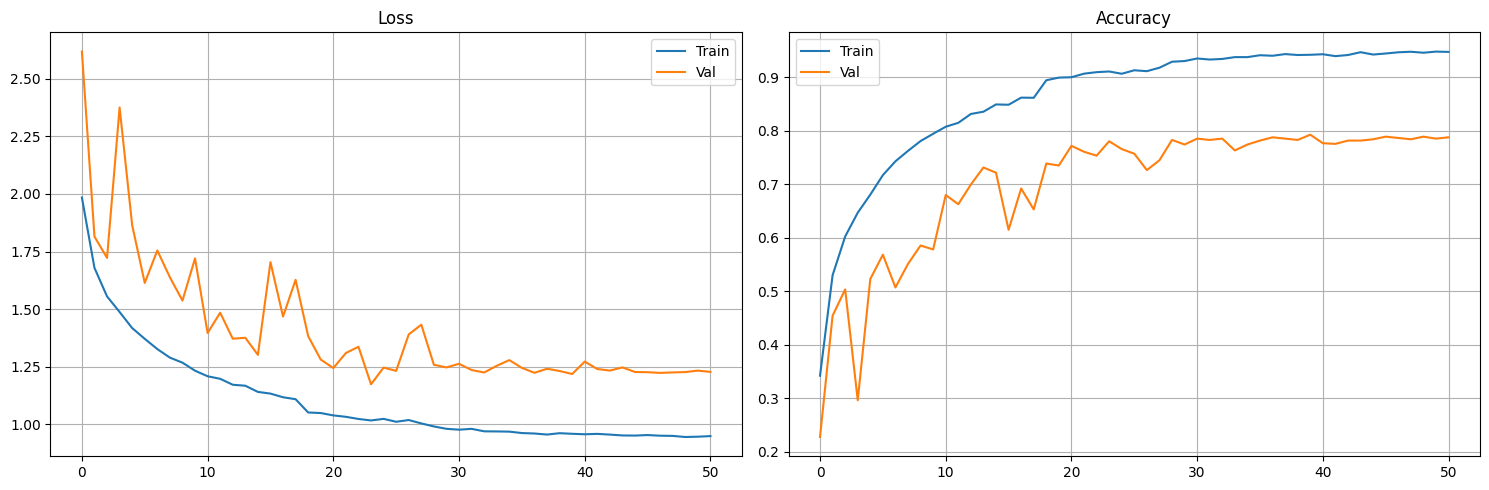

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Part 6. Evaluation

In [16]:
best_path = "best_urbansound_cnn.pt"
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print("\n" + "="*60)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print("="*60 + "\n")

Testing: 100%|██████████| 14/14 [00:55<00:00,  3.95s/it]


Test Accuracy: 78.26%



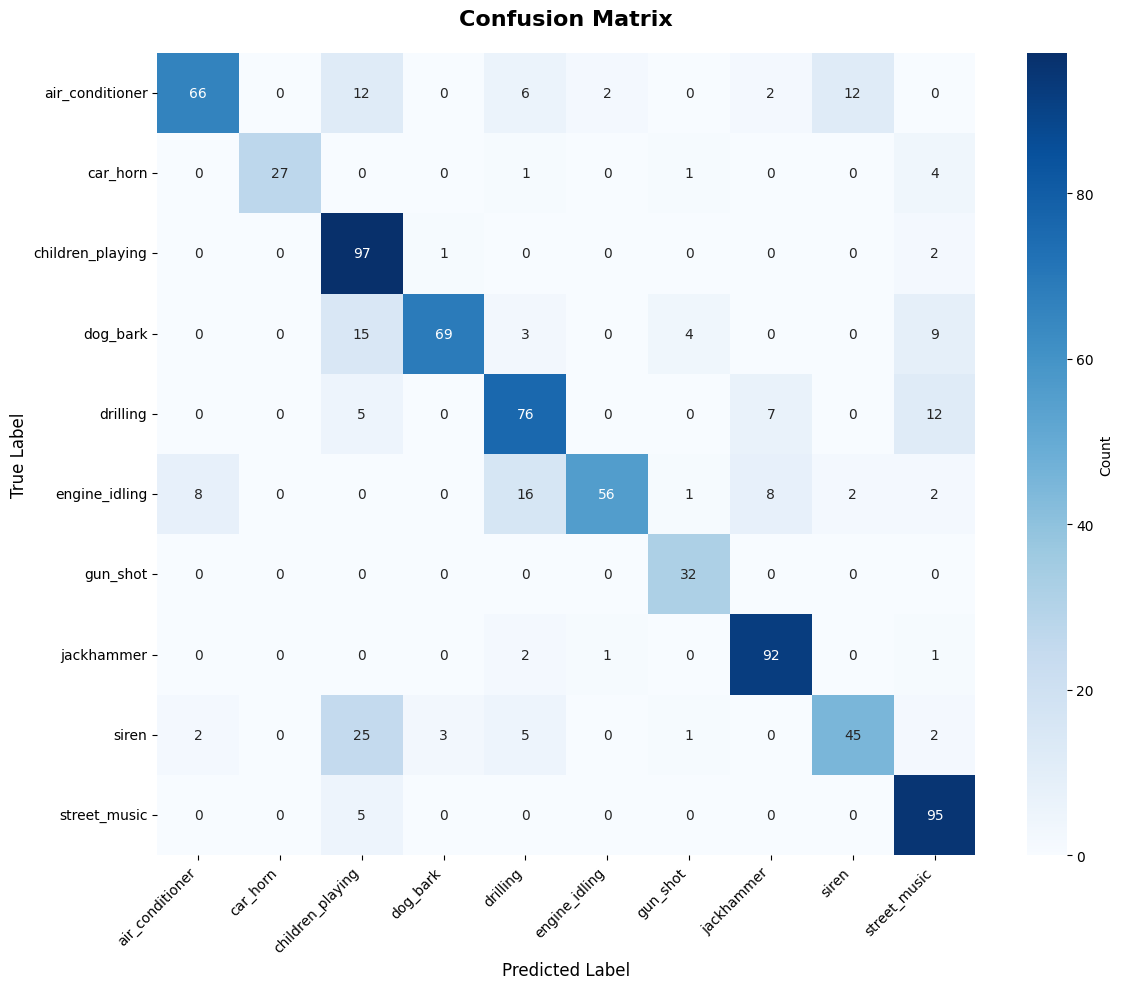

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

                  precision    recall  f1-score   support

 air_conditioner     0.8684    0.6600    0.7500       100
        car_horn     1.0000    0.8182    0.9000        33
children_playing     0.6101    0.9700    0.7490       100
        dog_bark     0.9452    0.6900    0.7977       100
        drilling     0.6972    0.7600    0.7273       100
   engine_idling     0.9492    0.6022    0.7368        93
        gun_shot     0.8205    1.0000    0.9014        32
      jackhammer     0.8440    0.9583    0.8976        96
           siren     0.7627    0.5422    0.6338        83
    street_music     0.7480    0.9500    0.8370       100

        accuracy                         0.7826       837
       macro avg     0.8245    0.7951    0.7931       837
    weighted avg     0.8109    0.7826    0.7789       837



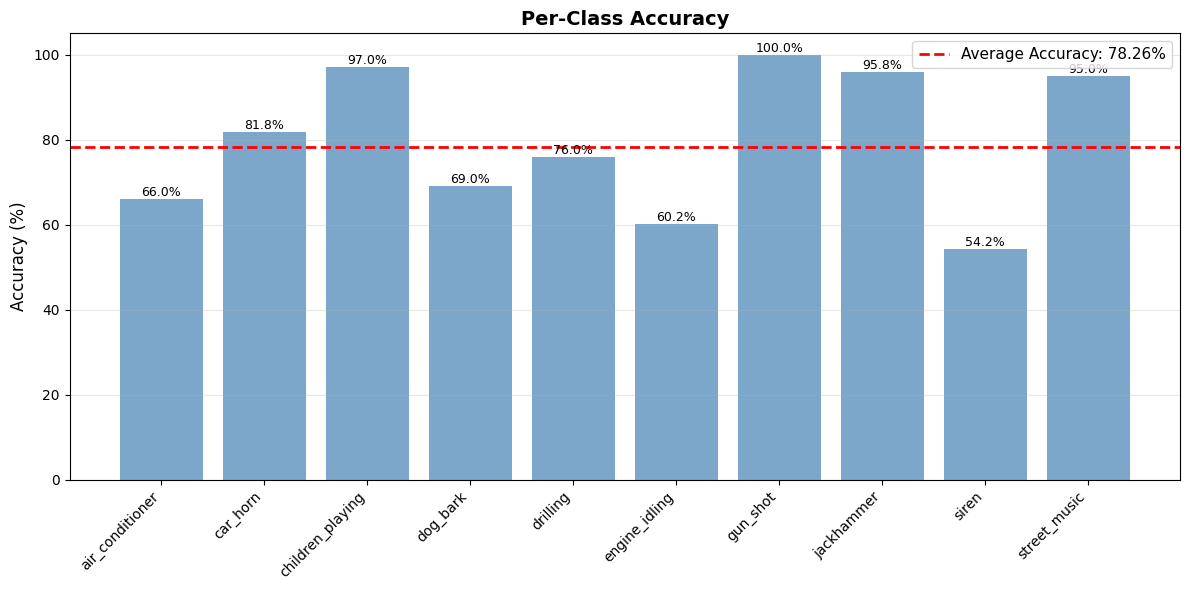

In [19]:
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(class_names)), per_class_acc, color='steelblue', alpha=0.7)
plt.axhline(y=test_acc * 100, color='red', linestyle='--', label=f'Average Accuracy: {test_acc*100:.2f}%', linewidth=2)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{per_class_acc[i]:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()